In [1]:
!pip install datasets pandas numpy scipy scikit-learn matplotlib seaborn -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datasets import load_dataset
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
GLOBAL_SEED = 42
Z_CUTOFF = 3
np.random.seed(GLOBAL_SEED)

source_data = load_dataset("gvlassis/california_housing")
data_raw = source_data["train"].to_pandas()

print(f"Исходный размер: {data_raw.shape}")
print(f"Названия столбцов: {list(data_raw.columns)}")

numeric_fields = data_raw.select_dtypes(include=['number']).columns.tolist()
print(f"\nЧисловые поля ({len(numeric_fields)}):")
for idx, name in enumerate(numeric_fields, 1):
    print(f"  {idx}. {name}")

print("\nСтатистика:")
data_raw.describe()

README.md: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/846k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


validation-00000-of-00001.parquet:   0%|          | 0.00/105k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/106k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16640 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Исходный размер: (16640, 9)
Названия столбцов: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

Числовые поля (9):
  1. MedInc
  2. HouseAge
  3. AveRooms
  4. AveBedrms
  5. Population
  6. AveOccup
  7. Latitude
  8. Longitude
  9. MedHouseVal

Статистика:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000
mean,3.797641,29.221995,5.396218,1.101687,1436.939123,3.007617,35.267714,-119.146628,2.018484
std,1.867145,12.797845,2.648682,0.511507,1159.762831,5.114548,2.086404,1.923576,1.132658
min,0.499900,1.000000,0.846154,0.375000,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.526300,19.000000,4.379310,1.007401,792.000000,2.425249,33.870000,-121.240000,1.183000
50%,3.474500,30.000000,5.166053,1.050725,1168.000000,2.831033,34.100000,-118.300000,1.736000
75%,4.635475,38.000000,6.000000,1.101127,1727.000000,3.309981,37.710000,-117.890000,2.530250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,599.714286,41.950000,-114.310000,5.000010


Удаление выбросов (метод IQR)
Поле 'MedInc': обработано 591 выбросов
Поле 'AveRooms': обработано 436 выбросов
Поле 'AveBedrms': обработано 1190 выбросов
Поле 'Population': обработано 1007 выбросов
Поле 'AveOccup': обработано 537 выбросов

Очистка завершена. Новый размер: (16640, 9)


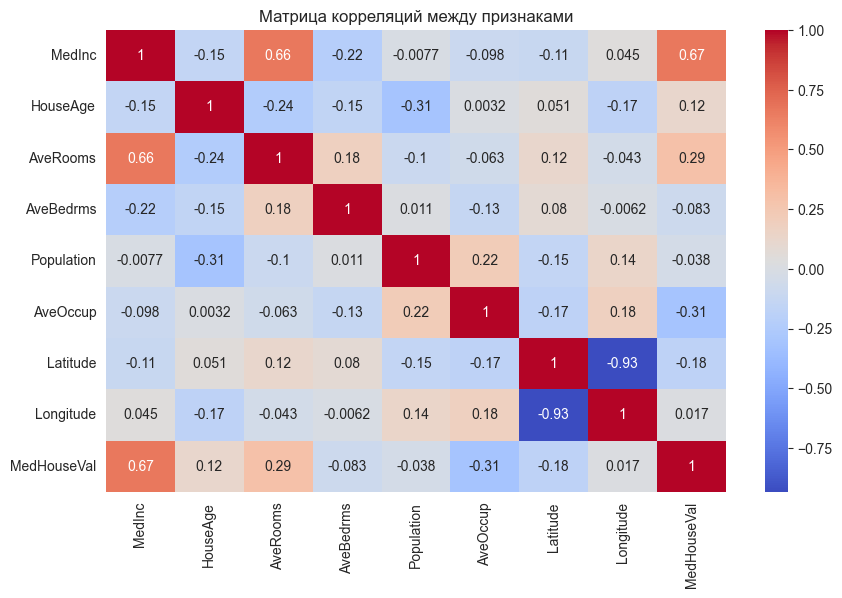

In [4]:
def clean_outliers_iqr(dataframe, cols_list):
    cleaned_data = dataframe.copy()
    for col_name in cols_list:
        q25 = dataframe[col_name].quantile(0.25)
        q75 = dataframe[col_name].quantile(0.75)
        iqr_span = q75 - q25
        low_limit = q25 - 1.5 * iqr_span
        high_limit = q75 + 1.5 * iqr_span
        cleaned_data[col_name] = np.clip(cleaned_data[col_name], low_limit, high_limit)
        outlier_num = ((dataframe[col_name] < low_limit) | (dataframe[col_name] > high_limit)).sum()
        if outlier_num > 0:
            print(f"Поле '{col_name}': обработано {outlier_num} выбросов")
    return cleaned_data

input_features = [col for col in numeric_fields if col != 'MedHouseVal']
print("Удаление выбросов (метод IQR)")
data_clean = clean_outliers_iqr(data_raw, input_features)
print(f"\nОчистка завершена. Новый размер: {data_clean.shape}")
plt.figure(figsize=(10, 6))
sns.heatmap(data_clean.corr(), annot=True, cmap='coolwarm')
plt.title("Матрица корреляций между признаками")
plt.show()

In [5]:
print("\nАнализ по Z-оценке")
for col_name in input_features:
    z_values = np.abs(stats.zscore(data_raw[col_name]))
    outlier_count = (z_values > Z_CUTOFF).sum()
    if outlier_count > 0:
        print(f"Поле '{col_name}': {outlier_count} выбросов (Z > {Z_CUTOFF})")


Анализ по Z-оценке
Поле 'MedInc': 268 выбросов (Z > 3)
Поле 'AveRooms': 118 выбросов (Z > 3)
Поле 'AveBedrms': 122 выбросов (Z > 3)
Поле 'Population': 270 выбросов (Z > 3)
Поле 'AveOccup': 10 выбросов (Z > 3)
Поле 'Latitude': 21 выбросов (Z > 3)


In [6]:
X_input = data_clean[input_features]
y_target = data_clean['MedHouseVal']

print(f"Исходное число признаков: {X_input.shape[1]}")

reg_model = LinearRegression()

feature_selector = SequentialFeatureSelector(
    reg_model,
    n_features_to_select='auto',
    direction='forward',
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

print("Запуск отбора признаков (жадный метод)")
feature_selector.fit(X_input, y_target)

final_features = [input_features[i] for i in range(len(input_features)) if feature_selector.get_support()[i]]
print(f"\nВыбрано признаков: {len(final_features)}")
print("Список выбранных признаков:")
for idx, feat in enumerate(final_features, 1):
    print(f"  {idx}. {feat}")

X_all = X_input
X_reduced = X_input[final_features]

model_with_all = LinearRegression().fit(X_all, y_target)
model_with_selected = LinearRegression().fit(X_reduced, y_target)

mse_all = mean_squared_error(y_target, model_with_all.predict(X_all))
mse_selected = mean_squared_error(y_target, model_with_selected.predict(X_reduced))

print(f"\nСравнение моделей:")
print(f"  Полная модель: MSE = {mse_all:.4f}")
print(f"  Модель с отбором ({len(final_features)} признаков): MSE = {mse_selected:.4f}")
print(f"  Разница MSE: {abs(mse_all - mse_selected):.4f}")

Исходное число признаков: 8
Запуск отбора признаков (жадный метод)

Выбрано признаков: 4
Список выбранных признаков:
  1. MedInc
  2. HouseAge
  3. AveRooms
  4. AveOccup

Сравнение моделей:
  Полная модель: MSE = 0.4516
  Модель с отбором (4 признаков): MSE = 0.5425
  Разница MSE: 0.0909


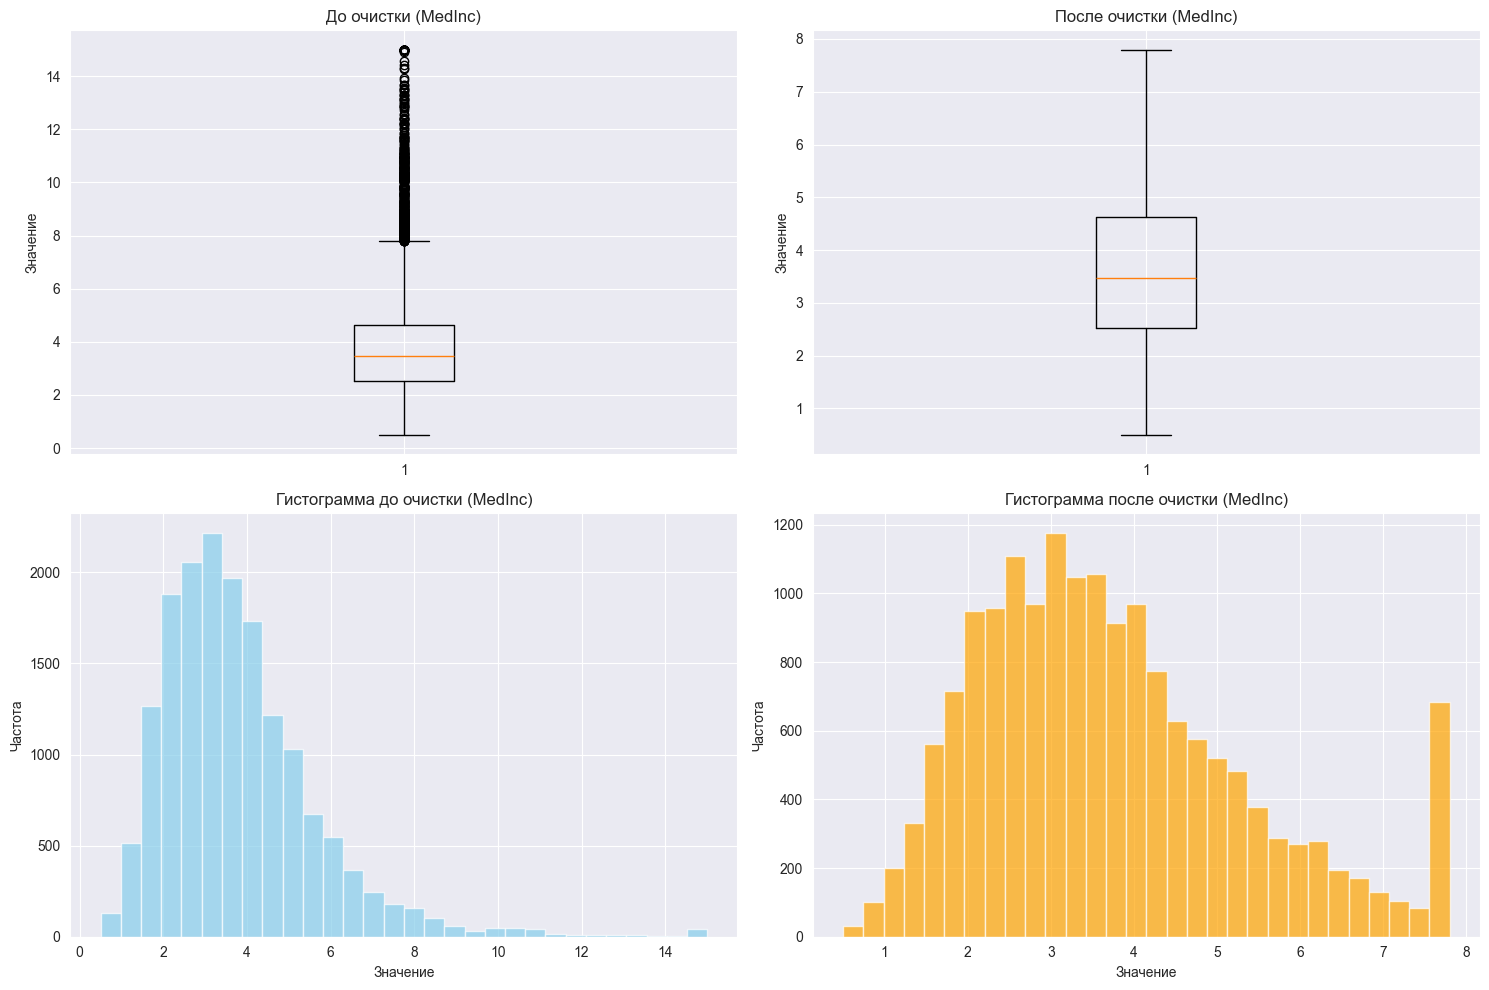

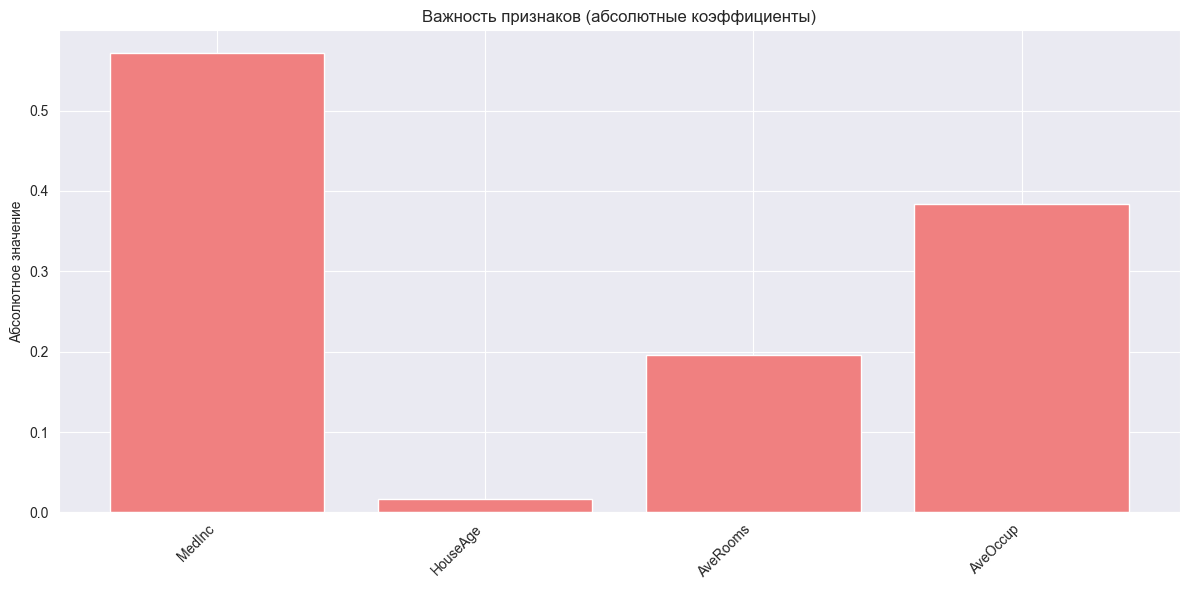

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

demo_col = 'MedInc'

axes[0, 0].boxplot(data_raw[demo_col])
axes[0, 0].set_title(f'До очистки ({demo_col})')
axes[0, 0].set_ylabel('Значение')

axes[0, 1].boxplot(data_clean[demo_col])
axes[0, 1].set_title(f'После очистки ({demo_col})')
axes[0, 1].set_ylabel('Значение')

axes[1, 0].hist(data_raw[demo_col], bins=30, alpha=0.7, color='skyblue')
axes[1, 0].set_title(f'Гистограмма до очистки ({demo_col})')
axes[1, 0].set_xlabel('Значение')
axes[1, 0].set_ylabel('Частота')

axes[1, 1].hist(data_clean[demo_col], bins=30, alpha=0.7, color='orange')
axes[1, 1].set_title(f'Гистограмма после очистки ({demo_col})')
axes[1, 1].set_xlabel('Значение')
axes[1, 1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

# Важность признаков
plt.figure(figsize=(12, 6))
importance_vals = [abs(model_with_selected.coef_[i]) for i in range(len(final_features))]
plt.bar(range(len(final_features)), importance_vals, color='lightcoral')
plt.xticks(range(len(final_features)), final_features, rotation=45, ha='right')
plt.title('Важность признаков (абсолютные коэффициенты)')
plt.ylabel('Абсолютное значение')
plt.tight_layout()
plt.show()

In [8]:
final_dataset = data_clean[final_features + ['MedHouseVal']].copy()

print("Финальный датасет")
print(f"Размер: {final_dataset.shape}")
print(f"Признаки: {list(final_dataset.columns[:-1])}")
print(f"Целевая переменная: {final_dataset.columns[-1]}")

print("\nПервые 5 строк:")
final_dataset.head()

print("\nСтатистика финального датасета:")
final_dataset.describe()

Финальный датасет
Размер: (16640, 5)
Признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup']
Целевая переменная: MedHouseVal

Первые 5 строк:

Статистика финального датасета:


,MedInc,HouseAge,AveRooms,AveOccup,MedHouseVal
count,16640.000000,16640.000000,16640.000000,16640.000000,16640.000000
mean,3.725837,29.221995,5.254555,2.912586,2.018484
std,1.617481,12.797845,1.256372,0.714709,1.132658
min,0.499900,1.000000,1.948276,1.098151,0.149990
25%,2.526300,19.000000,4.379310,2.425249,1.183000
50%,3.474500,30.000000,5.166053,2.831033,1.736000
75%,4.635475,38.000000,6.000000,3.309981,2.530250
max,7.799237,52.000000,8.431034,4.637078,5.000010
